## Part 0 & 1: Setup and Data Loading

In [2]:
# !pip install pandas numpy scikit-learn xgboost matplotlib seaborn
# !pip install shap lime eli5

In [14]:
# --- Part 0: Importing Our Toolboxes (Libraries) ---
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Import all the models we want to compare
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
# Import preparation and evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import shap

print("All libraries imported successfully!")

# --- Part 1: Load and Split The Data ---
try:
    df = pd.read_csv('UNSW_NB15_training.csv')
    print("Dataset loaded successfully!")
    
    # Clean columns if they exist
    columns_to_drop = ['id', 'attack_cat']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    if existing_columns_to_drop:
        df = df.drop(columns=existing_columns_to_drop, axis=1)
        print(f"Successfully removed columns: {existing_columns_to_drop}")

    X = df.drop('label', axis=1)
    y = df['label']

    # Split the single dataset into training (80%) and testing (20%) sets
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    print("Data successfully split into training and testing sets.")
except FileNotFoundError:
    print("Error: Make sure 'UNSW_NB15_training-set.csv' is in the same folder as this notebook.")

All libraries imported successfully!
Dataset loaded successfully!
Successfully removed columns: ['attack_cat']
Data successfully split into training and testing sets.


## Part 2: Preparing the Data (Preprocessing)

In [15]:
# --- Identify column types ---
categorical_features = X_train_raw.select_dtypes(include=['object']).columns
numerical_features = X_train_raw.select_dtypes(include=np.number).columns

# --- Create the preprocessor tool ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- Apply the preprocessing ---
print("Preprocessing data...")
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)
feature_names = preprocessor.get_feature_names_out()
print("Data preprocessing complete!")

Preprocessing data...
Data preprocessing complete!


## Part 3: Train and Evaluate All Models

In [17]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=500),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# --- A list to store the results ---
results = []

# --- Loop through each model to train and evaluate it ---
for model_name, model in models.items():
    print(f"--- Training {model_name} ---")

    # Measure training time
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    # Evaluate metrics
    y_pred = model.predict(X_test)
    
    # ✨ --- Calculate all the required metrics ---
    # Using 'weighted' average is robust for multi-class/imbalanced datasets
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100

    # ✨ --- Store all the results ---
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Training Time (s)": training_time
    })
    
    # ✨ --- Update the print statement to include the F1 Score ---
    print(f"{model_name} trained in {training_time:.2f}s | Accuracy: {accuracy:.2f}% | F1 Score: {f1:.2f}% | Recall: {recall:.2f}% | Precision: {precision:.2f}%")

# --- Convert the results list into a beautiful DataFrame table ---
results_df = pd.DataFrame(results)

--- Training Decision Tree ---
Decision Tree trained in 1.22s | Accuracy: 96.47% | F1 Score: 96.47% | Recall: 96.47% | Precision: 96.47%
--- Training MLP Classifier ---
MLP Classifier trained in 53.17s | Accuracy: 95.92% | F1 Score: 95.92% | Recall: 95.92% | Precision: 95.92%
--- Training XGBoost ---


C:\Users\Baba_\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [21:16:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained in 0.81s | Accuracy: 97.64% | F1 Score: 97.65% | Recall: 97.64% | Precision: 97.65%


## Part 4: Visualize Model Performance 📊

--- Initial Model Performance Comparison ---
         Model  Accuracy  Training Time (s)
       XGBoost 97.643772           1.366769
 Decision Tree 96.471731           1.339272
MLP Classifier 95.919111          54.918814


C:\Users\Baba_\AppData\Local\Temp\ipykernel_21672\1241013768.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Training Time (s)", y="Model", data=results_df, palette="plasma")


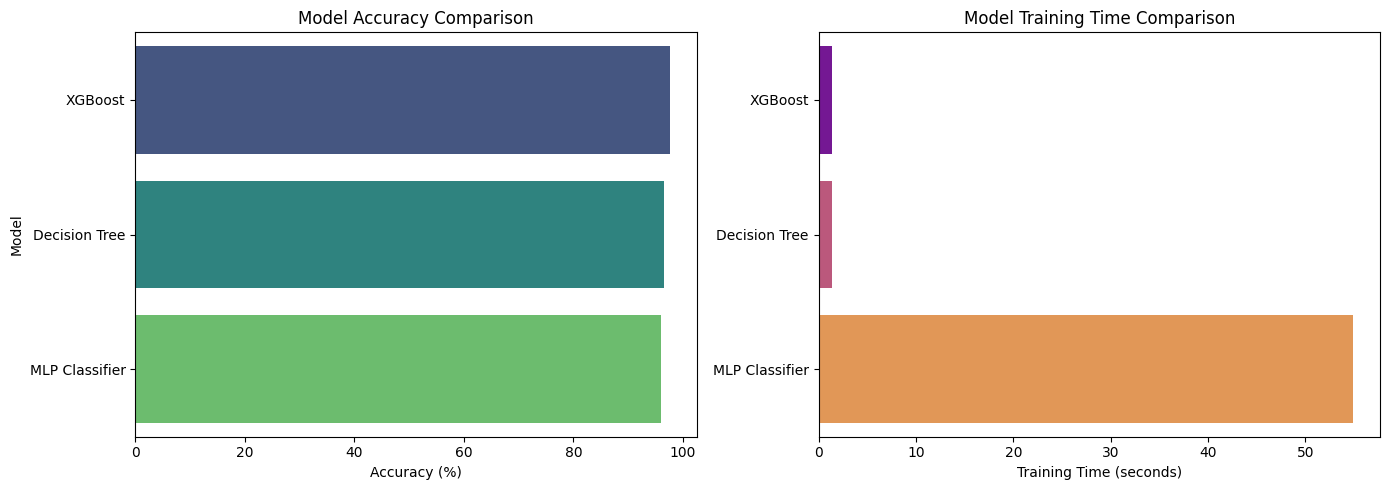

In [6]:
print("--- Initial Model Performance Comparison ---")
# Display the results table, sorted by accuracy
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print(results_df.to_string(index=False))


# --- Create plots to visualize the comparison ---
plt.figure(figsize=(14, 5))

# Plot 1: Accuracy Comparison
plt.subplot(1, 2, 1)
sns.barplot(x="Accuracy", y="Model", data=results_df, hue="Model", palette="viridis", legend=False)
plt.title("Model Accuracy Comparison")
plt.xlabel("Accuracy (%)")
plt.ylabel("Model")

# Plot 2: Training Time Comparison
plt.subplot(1, 2, 2)
sns.barplot(x="Training Time (s)", y="Model", data=results_df, palette="plasma")
plt.title("Model Training Time Comparison")
plt.xlabel("Training Time (seconds)")
plt.ylabel("") # Remove y-label for cleaner look

plt.tight_layout()
plt.show()

## Part 5: Selecting the Best Model and Applying XAI


--- Applying XAI to the Best Model (XGBoost) ---
Calculating feature importance using SHAP... This may take a few minutes.
Displaying SHAP Feature Importance Plot for XGBoost:


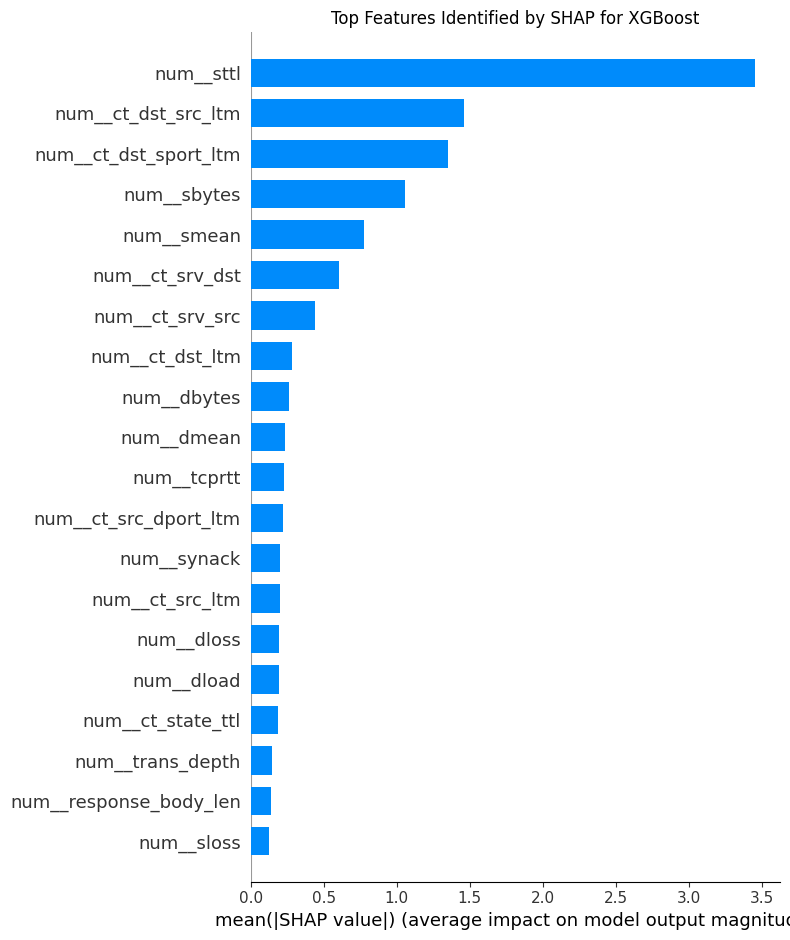

In [7]:
# --- We select our best model, which is the trained XGBoost model ---
best_model = models["XGBoost"]

# --- Use SHAP to explain the best model's decisions ---
print("\n--- Applying XAI to the Best Model (XGBoost) ---")
print("Calculating feature importance using SHAP... This may take a few minutes.")
explainer = shap.TreeExplainer(best_model)
X_test_sample = shap.sample(X_test, 1000) # Use a sample for speed
shap_values = explainer.shap_values(X_test_sample)

# --- Plot the SHAP results ---
print("Displaying SHAP Feature Importance Plot for XGBoost:")
plt.title("Top Features Identified by SHAP for XGBoost")
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", feature_names=feature_names)

## Part 6: Building the Lightweight Model

In [9]:
# --- Part 6: Building the Lightweight Model ---

# Convert processed data to DataFrames (CORRECTED: Removed .toarray())
# Since X_train and X_test are numpy.ndarrays, we can directly convert them.
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
print("Successfully converted processed data back into DataFrames.")

# AUTOMATED STEP: Find and select the Top 10 Features from SHAP results
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['feature_name', 'feature_importance_val'])
feature_importance.sort_values(by=['feature_importance_val'], ascending=False, inplace=True)
top_10_features_df = feature_importance.head(10) # Get DataFrame of top 10
top_10_features = top_10_features_df['feature_name'].tolist() # Get just the names as a list

print("\n" + "="*50)
print("      Feature Selection for Lightweight Model")
print("="*50)
print(f"Total features in Full Model: {X_train.shape[1]}")
print("\nTop 10 Features Identified by SHAP:")
# Print the top 10 features in a nice table format
print(top_10_features_df.to_string(index=False))
print("="*50)


# Create the lightweight datasets
X_train_lightweight = X_train_df[top_10_features]
X_test_lightweight = X_test_df[top_10_features]

# Build and Train the Lightweight Model
lightweight_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
print("\nTraining the Lightweight Model on only 10 features...")
start_time = time.time()
lightweight_model.fit(X_train_lightweight, y_train)
end_time = time.time()
lightweight_model_time = end_time - start_time
y_pred_lightweight = lightweight_model.predict(X_test_lightweight)
lightweight_model_accuracy = accuracy_score(y_test, y_pred_lightweight)

# Part 7 (Moved to this cell for convenience in presentation)
# --- Final Comparison of Full vs. Lightweight XGBoost ---
print("\n" + "="*60)
print("          FINAL XGBOOST MODEL COMPARISON")
print("="*60)
# Let's grab the full model's results from our earlier table
full_model_stats = results_df[results_df['Model'] == 'XGBoost'].iloc[0]
print(f"| Metric                | Full XGBoost Model | Lightweight XGBoost Model |")
print(f"|-----------------------|--------------------|---------------------------|")
print(f"| Number of Features    | {X_train.shape[1]:<18} | {X_train_lightweight.shape[1]:<25} |")
print(f"| Accuracy              | {full_model_stats['Accuracy']:<18.2f}% | {lightweight_model_accuracy*100:<25.2f}% |")
print(f"| Training Time (sec)   | {full_model_stats['Training Time (s)']:<18.2f} | {lightweight_model_time:<25.2f} |")
print("="*60)

Successfully converted processed data back into DataFrames.

      Feature Selection for Lightweight Model
Total features in Full Model: 39

Top 10 Features Identified by SHAP:
         feature_name  feature_importance_val
            num__sttl                3.451165
  num__ct_dst_src_ltm                1.460100
num__ct_dst_sport_ltm                1.348982
          num__sbytes                1.056261
           num__smean                0.773659
      num__ct_srv_dst                0.602477
      num__ct_srv_src                0.443963
      num__ct_dst_ltm                0.285410
          num__dbytes                0.264313
           num__dmean                0.237030

Training the Lightweight Model on only 10 features...


C:\Users\Baba_\AppData\Roaming\Python\Python310\site-packages\xgboost\training.py:183: UserWarning: [15:20:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



          FINAL XGBOOST MODEL COMPARISON
| Metric                | Full XGBoost Model | Lightweight XGBoost Model |
|-----------------------|--------------------|---------------------------|
| Number of Features    | 39                 | 10                        |
| Accuracy              | 97.64             % | 97.30                    % |
| Training Time (sec)   | 1.37               | 0.45                      |


## Part 7: Final Comparison of Full vs. Lightweight XGBoost 

In [11]:
# --- Create a final, presentable DataFrame for comparison ---

# Get the stats for the full XGBoost model from our initial comparison table
full_model_stats = results_df[results_df['Model'] == 'XGBoost'].iloc[0]

# Organize the data
metrics = ["Accuracy (%)", "Training Time (s)", "Number of Features"]
full_model_values = [
    full_model_stats['Accuracy'],
    full_model_stats['Training Time (s)'],
    X_train.shape[1]
]
lightweight_model_values = [
    lightweight_model_accuracy * 100,
    lightweight_model_time,
    X_train_lightweight.shape[1]
]

# Create the DataFrame
summary_df = pd.DataFrame({
    'Metric': metrics,
    'Full XGBoost Model': full_model_values,
    'Lightweight XGBoost Model': lightweight_model_values
})

# --- Calculate the "Change" column ---
# Calculate the percentage change for each metric
accuracy_change = summary_df.iloc[0, 2] - summary_df.iloc[0, 1]
time_change = ((summary_df.iloc[1, 2] - summary_df.iloc[1, 1]) / summary_df.iloc[1, 1]) * 100
features_change = ((summary_df.iloc[2, 2] - summary_df.iloc[2, 1]) / summary_df.iloc[2, 1]) * 100

summary_df['Change'] = [f"{accuracy_change:.2f}%", f"{time_change:.2f}%", f"{features_change:.2f}%"]

# --- Style and display the final table ---
# We'll set the 'Metric' column as the index for a cleaner look
summary_df.set_index('Metric', inplace=True)

# Format the numeric columns to two decimal places
summary_df['Full XGBoost Model'] = summary_df['Full XGBoost Model'].map('{:.2f}'.format)
summary_df['Lightweight XGBoost Model'] = summary_df['Lightweight XGBoost Model'].map('{:.2f}'.format)


print("\n" + "="*75)
print("                  FINAL XGBOOST MODEL COMPARISON")
print("="*75)
print(summary_df)
print("="*75)


                  FINAL XGBOOST MODEL COMPARISON
                   Full XGBoost Model Lightweight XGBoost Model   Change
Metric                                                                  
Accuracy (%)                    97.64                     97.30   -0.35%
Training Time (s)                1.37                      0.45  -67.21%
Number of Features              39.00                     10.00  -74.36%


## Part 8: Visualizing the Final Comparison 📈


C:\Users\Baba_\AppData\Local\Temp\ipykernel_2216\563035604.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy (%)', data=final_df, ax=axes[0], palette='Greens')
C:\Users\Baba_\AppData\Local\Temp\ipykernel_2216\563035604.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Training Time (s)', data=final_df, ax=axes[1], palette='Blues')
C:\Users\Baba_\AppData\Local\Temp\ipykernel_2216\563035604.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Number of Features', data=final_df, ax=axes[2

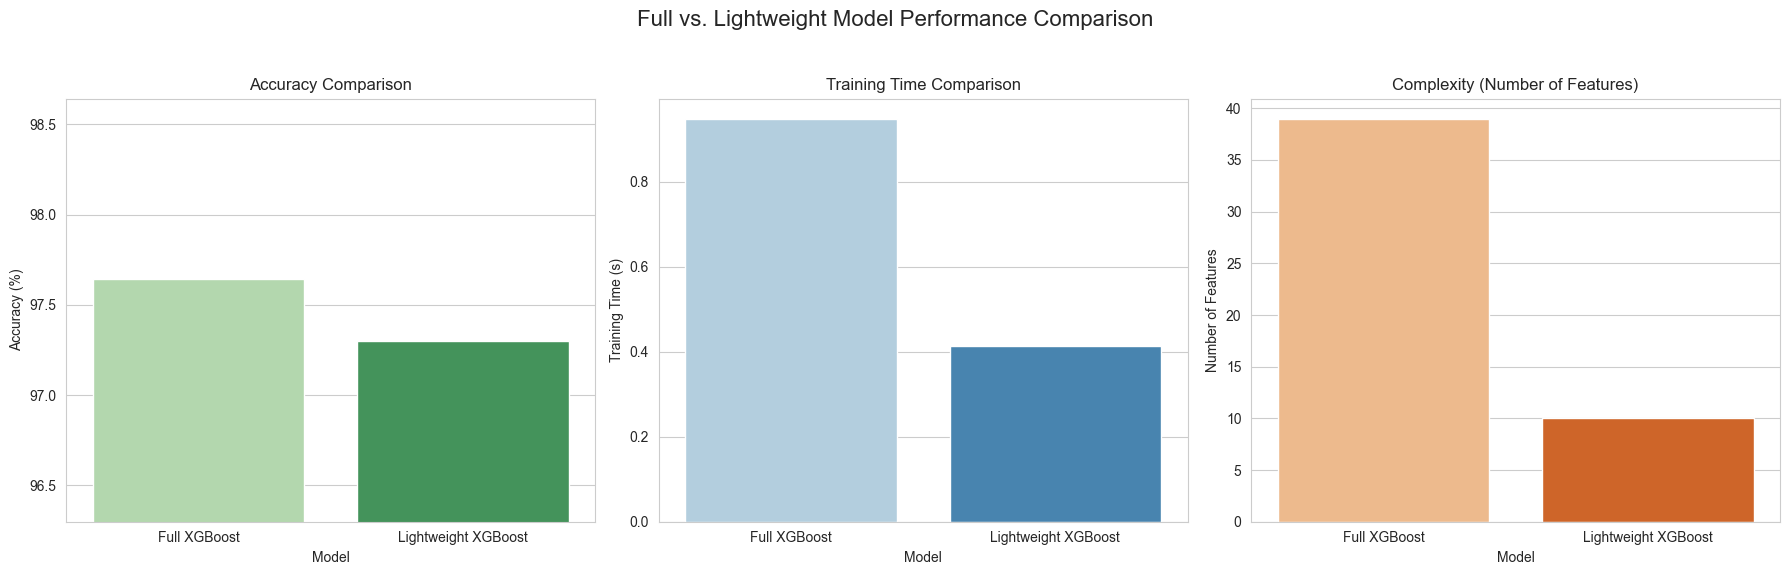

In [ ]:
# --- Create a new DataFrame with the final results for easy plotting ---
final_comparison_data = {
    'Model': ['Full XGBoost', 'Lightweight XGBoost'],
    'Accuracy (%)': [full_model_stats['Accuracy'], lightweight_model_accuracy * 100],
    'Training Time (s)': [full_model_stats['Training Time (s)'], lightweight_model_time],
    'Number of Features': [X_train.shape[1], X_train_lightweight.shape[1]]
}
final_df = pd.DataFrame(final_comparison_data)

# --- Create the plots ---
# We'll create a figure with 3 subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Full vs. Lightweight Model Performance Comparison', fontsize=16)

# Plot 1: Accuracy Comparison
sns.barplot(x='Model', y='Accuracy (%)', data=final_df, ax=axes[0], palette='Greens')
axes[0].set_title('Accuracy Comparison')
# We set the y-axis limit to zoom in on the small difference in accuracy
axes[0].set_ylim(min(final_df['Accuracy (%)']) - 1, max(final_df['Accuracy (%)']) + 1) 

# Plot 2: Training Time Comparison
sns.barplot(x='Model', y='Training Time (s)', data=final_df, ax=axes[1], palette='Blues')
axes[1].set_title('Training Time Comparison')

# Plot 3: Number of Features Comparison
sns.barplot(x='Model', y='Number of Features', data=final_df, ax=axes[2], palette='Oranges')
axes[2].set_title('Complexity (Number of Features)')

# --- Display the plots ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for the suptitle
plt.show()